In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uuid
from typing import List

import model
from helpers.files import load_config

In [3]:
config = load_config("config.json")

# Dataset

## Load

In [4]:
def fashion_mnist():
    """Function to load the fashion mnist dataset.

    :returns: Tuple of features, targets and labels.
    """
    labels = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)

    X = X.reshape((-1, 28, 28, 1))
    y = y.reshape((-1, 1))

    return X.astype(np.float32), y.astype(np.float32), labels

def cifar10():
    """Function to load the CIFAR10 dataset.

    :returns: Tuple of features, targets and labels.
    """
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)

    y = y.reshape(-1, 1)

    return X.astype(np.float32), y.astype(np.float32), labels

In [5]:
dataset_func = cifar10 if config['dataset'] == "cifar10" else fashion_mnist
X_train, y_train, labels = dataset_func()

## Build pipeline

One of the best practices when building DCGAN, is to use `tanh` as the last activation function for the generator. With that
it would be better to scale the inputs to appropriate scale between [-1, 1]

In [6]:
def preprocessing(X_instance):
    """
    Normalize the features and scale them to [-1, 1]

    :param X_instance: Instance of the training set.
    :return: normalized instance.
    """
    X_instance = X_instance / 255.
    return X_instance * 2. - 1.

In [7]:
batch_size = int(config['batch_size'])

# create datasets
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_train_dataset = X_train_dataset.map(preprocessing)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
train_dataset = train_dataset.shuffle(10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Conditional DCGAN

## Generator and Discriminator

The original paper of CGAN used onehot encoding 

In [8]:
n_classes = len(labels)
img_dims = X_train.shape[1:]
embeddings_dim = config['embeddings_dim']
label_encoding = config['label_encoding']
codings_size = int(config['codings_size'])

if label_encoding == "embeddings":
    generator = model.build_generator(image_dims=img_dims, n_classes=n_classes,
                                      codings_size=codings_size, embedding_dims=embeddings_dim)
    discriminator = model.build_discriminator(image_dims=img_dims, n_classes=n_classes, embedding_dims=embeddings_dim)
elif label_encoding == "onehot":
    generator = model.build_generator(image_dims=img_dims, n_classes=n_classes, codings_size=codings_size)
    discriminator = model.build_discriminator(image_dims=img_dims, n_classes=n_classes)
else:
    raise ValueError("label_encoding can be either embeddings or onehot.")

## Training

In [9]:
epochs = config['epochs']
loss = config['loss']
g_optimizer = tf.keras.optimizers.get(config['g_optimizer'])
d_optimizer = tf.keras.optimizers.get(config['d_optimizer'])


c_dcgan = model.ConditionalDCGAN(generator=generator, discriminator=discriminator,
                                 codings_size=codings_size, n_classes=n_classes)

Epoch 1/100
1875/1875 [==============================] - 335s 177ms/step - d_loss: 0.5864 - g_loss: 1.4387


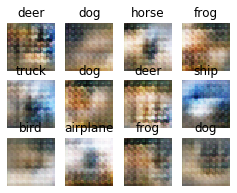

Epoch 2/100
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6012 - g_loss: 1.2579


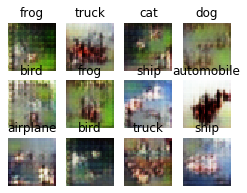

Epoch 3/100
1875/1875 [==============================] - 323s 172ms/step - d_loss: 0.6320 - g_loss: 1.0876


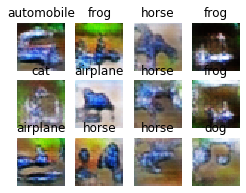

Epoch 4/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.6477 - g_loss: 0.9946


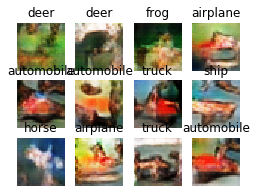

Epoch 5/100
1875/1875 [==============================] - 320s 171ms/step - d_loss: 0.6381 - g_loss: 1.0281


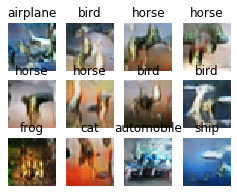

Epoch 6/100
1875/1875 [==============================] - 319s 170ms/step - d_loss: 0.6316 - g_loss: 1.0500


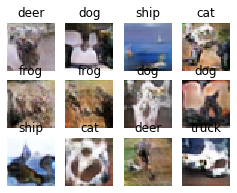

Epoch 7/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.6271 - g_loss: 1.0550


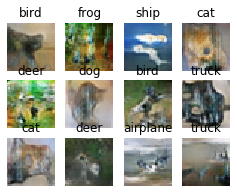

Epoch 8/100
1875/1875 [==============================] - 321s 171ms/step - d_loss: 0.6193 - g_loss: 1.0844


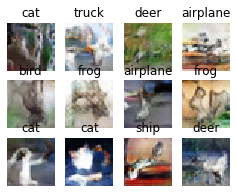

Epoch 9/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.6172 - g_loss: 1.0909


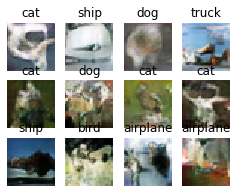

Epoch 10/100
1875/1875 [==============================] - 322s 171ms/step - d_loss: 0.6131 - g_loss: 1.1071


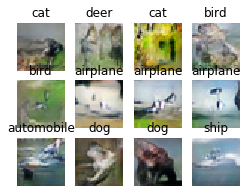

Epoch 11/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.6101 - g_loss: 1.1138


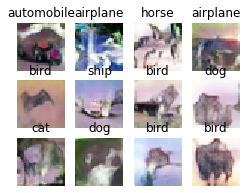

Epoch 12/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.6066 - g_loss: 1.1366


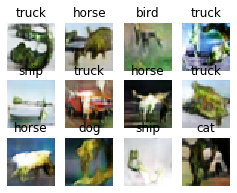

Epoch 13/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5962 - g_loss: 1.1721


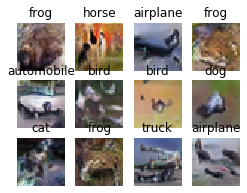

Epoch 14/100
1875/1875 [==============================] - 315s 168ms/step - d_loss: 0.5913 - g_loss: 1.2015


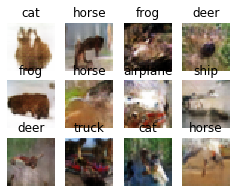

Epoch 15/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.5832 - g_loss: 1.2233


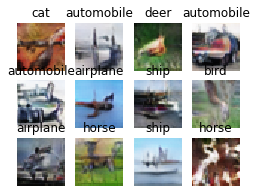

Epoch 16/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.5780 - g_loss: 1.2525


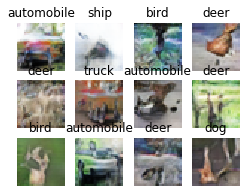

Epoch 17/100
1875/1875 [==============================] - 315s 168ms/step - d_loss: 0.5732 - g_loss: 1.2666


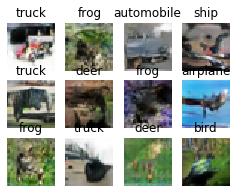

Epoch 18/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5666 - g_loss: 1.3103


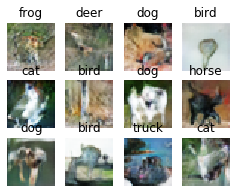

Epoch 19/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5589 - g_loss: 1.3348


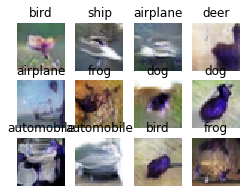

Epoch 20/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5560 - g_loss: 1.3440


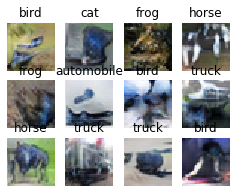

Epoch 21/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5534 - g_loss: 1.3678


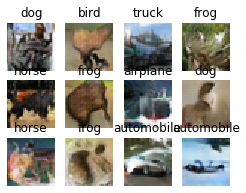

Epoch 22/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5497 - g_loss: 1.3927


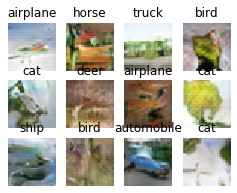

Epoch 23/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5458 - g_loss: 1.4024


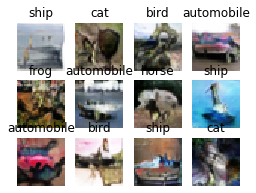

Epoch 24/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5460 - g_loss: 1.4088


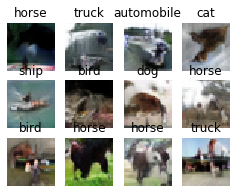

Epoch 25/100
1875/1875 [==============================] - 318s 169ms/step - d_loss: 0.5420 - g_loss: 1.4346


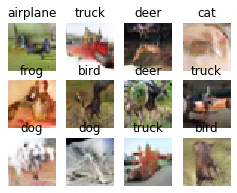

Epoch 26/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5404 - g_loss: 1.4372


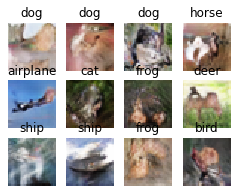

Epoch 27/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.5364 - g_loss: 1.4638


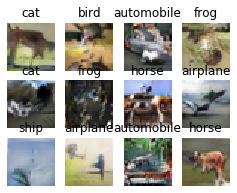

Epoch 28/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5356 - g_loss: 1.4673


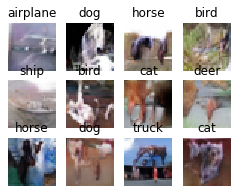

Epoch 29/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5326 - g_loss: 1.4892


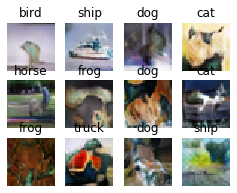

Epoch 30/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5301 - g_loss: 1.4997


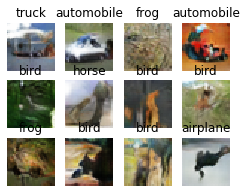

Epoch 31/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.5273 - g_loss: 1.5069


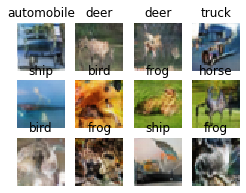

Epoch 32/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.5242 - g_loss: 1.5211


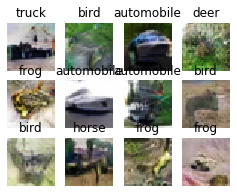

Epoch 33/100
1875/1875 [==============================] - 308s 164ms/step - d_loss: 0.5215 - g_loss: 1.5384


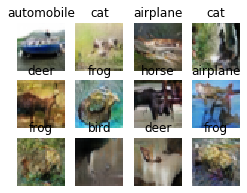

Epoch 34/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5178 - g_loss: 1.5609


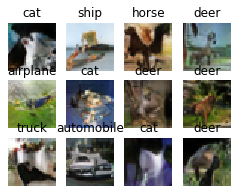

Epoch 35/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5167 - g_loss: 1.5748


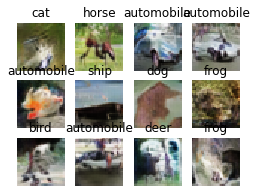

Epoch 36/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.5126 - g_loss: 1.5858


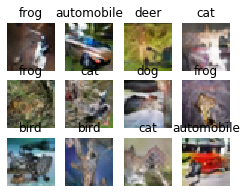

Epoch 37/100
1875/1875 [==============================] - 310s 165ms/step - d_loss: 0.5131 - g_loss: 1.5891


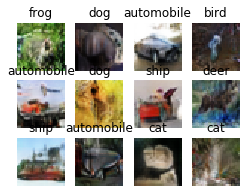

Epoch 38/100
1875/1875 [==============================] - 315s 168ms/step - d_loss: 0.5112 - g_loss: 1.6078


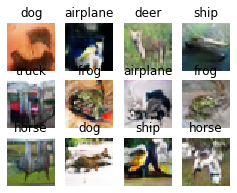

Epoch 39/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.5070 - g_loss: 1.6160


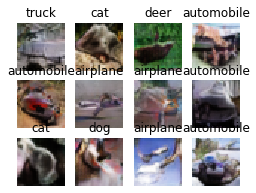

Epoch 40/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.5066 - g_loss: 1.6298


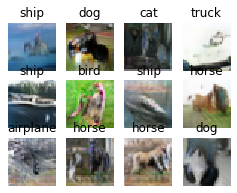

Epoch 41/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5037 - g_loss: 1.6475


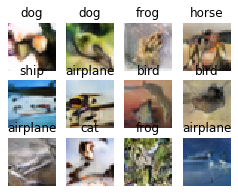

Epoch 42/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.5014 - g_loss: 1.6675


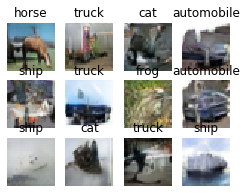

Epoch 43/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4980 - g_loss: 1.6884


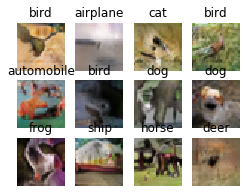

Epoch 44/100
1875/1875 [==============================] - 315s 167ms/step - d_loss: 0.4957 - g_loss: 1.6916


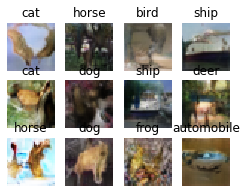

Epoch 45/100
1875/1875 [==============================] - 318s 169ms/step - d_loss: 0.4914 - g_loss: 1.7143


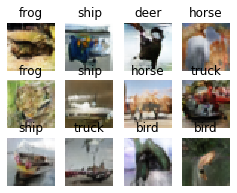

Epoch 46/100
1875/1875 [==============================] - 319s 170ms/step - d_loss: 0.4911 - g_loss: 1.7305


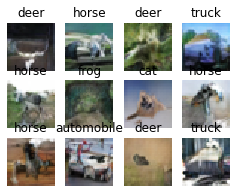

Epoch 47/100
1875/1875 [==============================] - 318s 169ms/step - d_loss: 0.4893 - g_loss: 1.7459


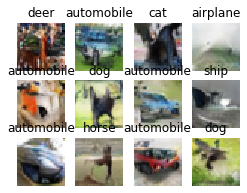

Epoch 48/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.4889 - g_loss: 1.7464


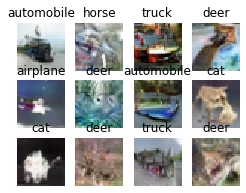

Epoch 49/100
1875/1875 [==============================] - 319s 170ms/step - d_loss: 0.4834 - g_loss: 1.7654


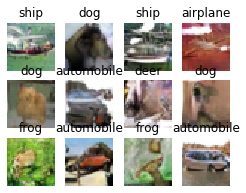

Epoch 50/100
1875/1875 [==============================] - 304s 161ms/step - d_loss: 0.4828 - g_loss: 1.7845


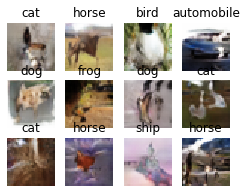

Epoch 51/100
1875/1875 [==============================] - 296s 158ms/step - d_loss: 0.4811 - g_loss: 1.8006


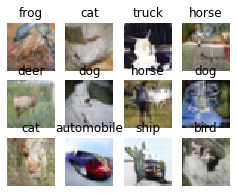

Epoch 52/100
1875/1875 [==============================] - 306s 163ms/step - d_loss: 0.4793 - g_loss: 1.8066


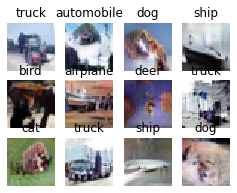

Epoch 53/100
1875/1875 [==============================] - 310s 165ms/step - d_loss: 0.4753 - g_loss: 1.8278


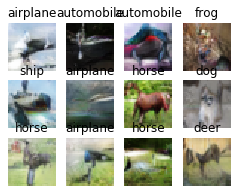

Epoch 54/100
1875/1875 [==============================] - 309s 165ms/step - d_loss: 0.4758 - g_loss: 1.8404


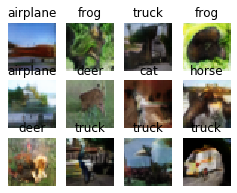

Epoch 55/100
1875/1875 [==============================] - 310s 165ms/step - d_loss: 0.4722 - g_loss: 1.8536


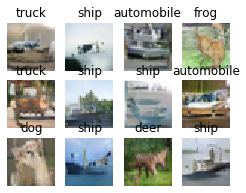

Epoch 56/100
1875/1875 [==============================] - 306s 163ms/step - d_loss: 0.4693 - g_loss: 1.8600


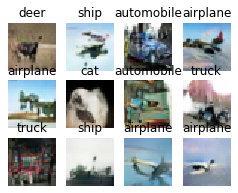

Epoch 57/100
1875/1875 [==============================] - 275s 147ms/step - d_loss: 0.4664 - g_loss: 1.8803


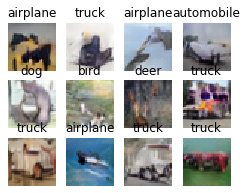

Epoch 58/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.4640 - g_loss: 1.9031


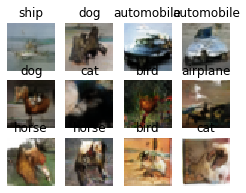

Epoch 59/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.4614 - g_loss: 1.9256


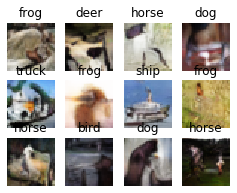

Epoch 60/100
1875/1875 [==============================] - 269s 143ms/step - d_loss: 0.4622 - g_loss: 1.9301


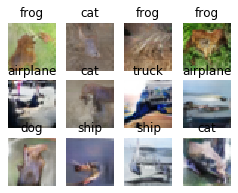

Epoch 61/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.4576 - g_loss: 1.9500


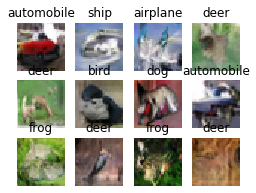

Epoch 62/100
1875/1875 [==============================] - 272s 145ms/step - d_loss: 0.4570 - g_loss: 1.9613


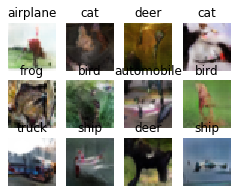

Epoch 63/100
1875/1875 [==============================] - 301s 160ms/step - d_loss: 0.4559 - g_loss: 1.9690


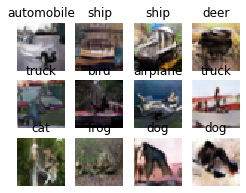

Epoch 64/100
1875/1875 [==============================] - 328s 175ms/step - d_loss: 0.4533 - g_loss: 1.9916


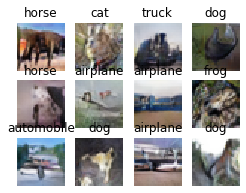

Epoch 65/100
1875/1875 [==============================] - 332s 177ms/step - d_loss: 0.4520 - g_loss: 1.9951


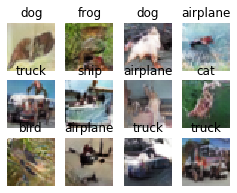

Epoch 66/100
1875/1875 [==============================] - 328s 175ms/step - d_loss: 0.4493 - g_loss: 2.0117


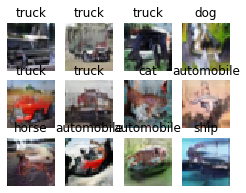

Epoch 67/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.4489 - g_loss: 2.0178


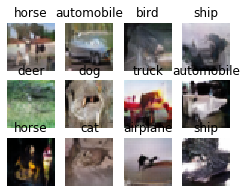

Epoch 68/100
1875/1875 [==============================] - 314s 168ms/step - d_loss: 0.4460 - g_loss: 2.0438


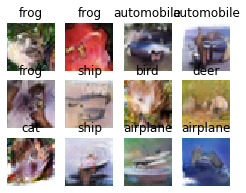

Epoch 69/100
1875/1875 [==============================] - 316s 169ms/step - d_loss: 0.4451 - g_loss: 2.0541


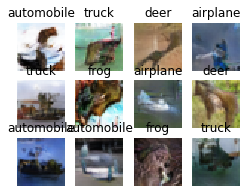

Epoch 70/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.4430 - g_loss: 2.0649


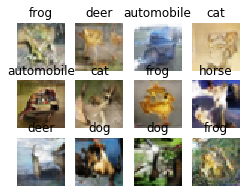

Epoch 71/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.4398 - g_loss: 2.0747


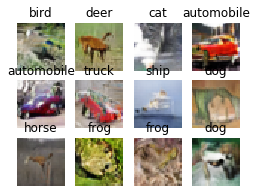

Epoch 72/100
1875/1875 [==============================] - 319s 170ms/step - d_loss: 0.4399 - g_loss: 2.0958


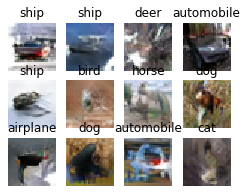

Epoch 73/100
1875/1875 [==============================] - 318s 170ms/step - d_loss: 0.4380 - g_loss: 2.0923


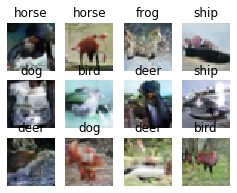

Epoch 74/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4354 - g_loss: 2.0903


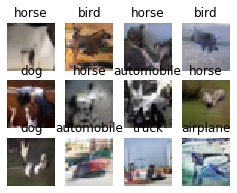

Epoch 75/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4347 - g_loss: 2.1321


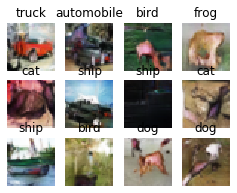

Epoch 76/100
1875/1875 [==============================] - 318s 170ms/step - d_loss: 0.4332 - g_loss: 2.1334


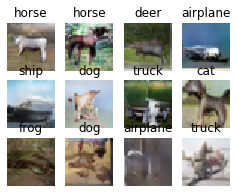

Epoch 77/100
1875/1875 [==============================] - 309s 165ms/step - d_loss: 0.4306 - g_loss: 2.1398


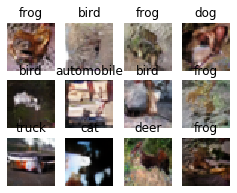

Epoch 78/100
1875/1875 [==============================] - 311s 166ms/step - d_loss: 0.4288 - g_loss: 2.1554


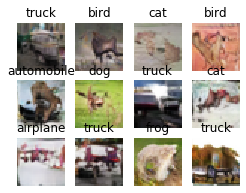

Epoch 79/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4270 - g_loss: 2.1780


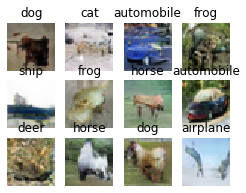

Epoch 80/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4266 - g_loss: 2.1845


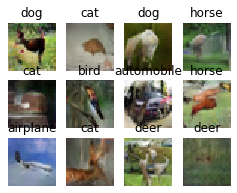

Epoch 81/100
1875/1875 [==============================] - 314s 167ms/step - d_loss: 0.4227 - g_loss: 2.2089


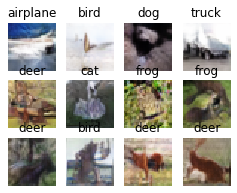

Epoch 82/100
1875/1875 [==============================] - 312s 166ms/step - d_loss: 0.4221 - g_loss: 2.2115


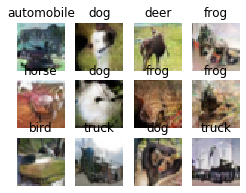

Epoch 83/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4210 - g_loss: 2.2198


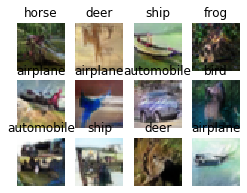

Epoch 84/100
1875/1875 [==============================] - 320s 170ms/step - d_loss: 0.4204 - g_loss: 2.2347


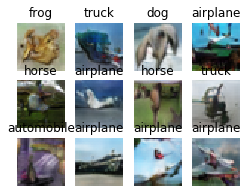

Epoch 85/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.4219 - g_loss: 2.2256


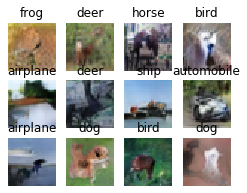

Epoch 86/100
1875/1875 [==============================] - 315s 167ms/step - d_loss: 0.4175 - g_loss: 2.2314


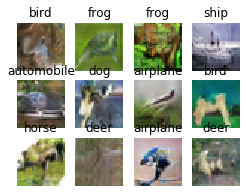

Epoch 87/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4165 - g_loss: 2.2551


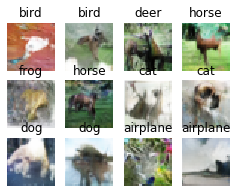

Epoch 88/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4145 - g_loss: 2.2766


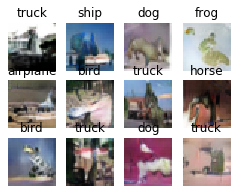

Epoch 89/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4130 - g_loss: 2.2921


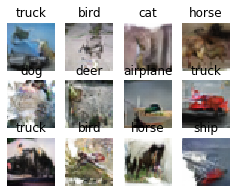

Epoch 90/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4127 - g_loss: 2.3052


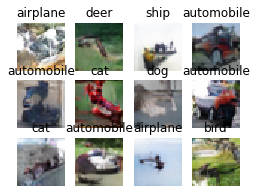

Epoch 91/100
1875/1875 [==============================] - 318s 169ms/step - d_loss: 0.4110 - g_loss: 2.3041


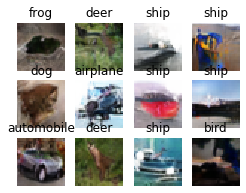

Epoch 92/100
1875/1875 [==============================] - 316s 168ms/step - d_loss: 0.4110 - g_loss: 2.3146


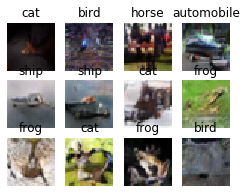

Epoch 93/100
1875/1875 [==============================] - 319s 170ms/step - d_loss: 0.4086 - g_loss: 2.3301


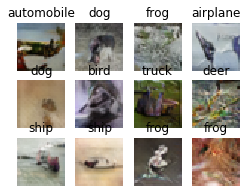

Epoch 94/100
1875/1875 [==============================] - 318s 170ms/step - d_loss: 0.4131 - g_loss: 2.3214


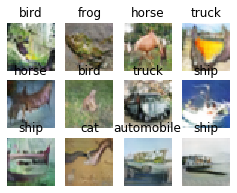

Epoch 95/100
1875/1875 [==============================] - 321s 171ms/step - d_loss: 0.4038 - g_loss: 2.3514


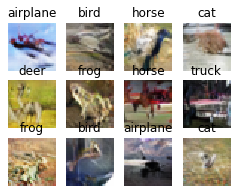

Epoch 96/100
1875/1875 [==============================] - 317s 169ms/step - d_loss: 0.4070 - g_loss: 2.3531


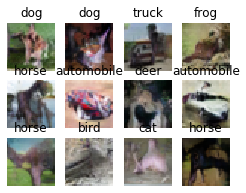

Epoch 97/100
1875/1875 [==============================] - 315s 168ms/step - d_loss: 0.4065 - g_loss: 2.3472


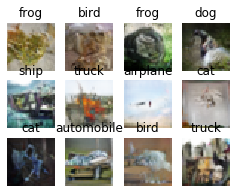

Epoch 98/100
1875/1875 [==============================] - 318s 169ms/step - d_loss: 0.4034 - g_loss: 2.3749


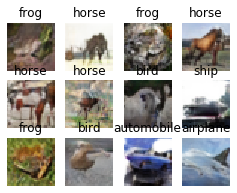

Epoch 99/100
1875/1875 [==============================] - 323s 172ms/step - d_loss: 0.4029 - g_loss: 2.3760


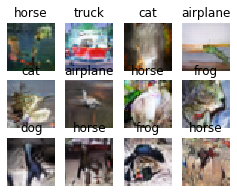

Epoch 100/100
1875/1875 [==============================] - 328s 175ms/step - d_loss: 0.4021 - g_loss: 2.3782


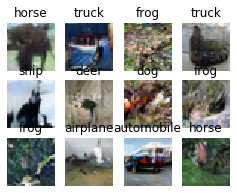

In [10]:
c_dcgan.compile(d_optimizer=d_optimizer, g_optimizer=g_optimizer, loss=loss)
history = c_dcgan.fit(train_dataset, epochs=epochs, callbacks=[model.VisualizeSample(labels)])

# Evaluation

In [18]:
def plot_reconstructions(reconstructions, labels: List[int], classes: List[str], save: bool = True):
    if reconstructions.shape[-1] == 1:
        reconstructions = np.squeeze(reconstructions, axis=-1)

    for reconstruction, label in zip(reconstructions, labels):
        label_name = classes[label]
        plt.imshow(reconstruction, cmap='binary')
        plt.title(label_name)
        plt.axis("off")
        if save:
            random_str = str(uuid.uuid1())[:12]
            plt.savefig("images/{}_{}.png".format(label_name, random_str))
        plt.show()

Let's evaluate the model by predicting an airplane

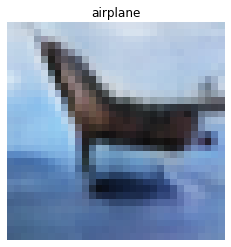

In [22]:
airplane_label = labels.index('airplane')
airplane_reconstruction = c_dcgan.generate(size=1, labels=airplane_label)
plot_reconstructions(airplane_reconstruction, [airplane_label], labels)

Let's generate a label for each class.

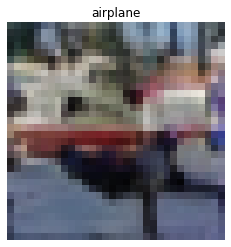

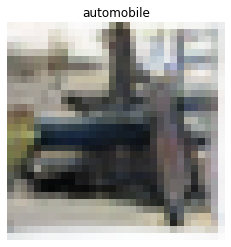

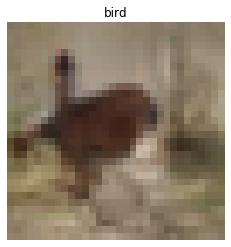

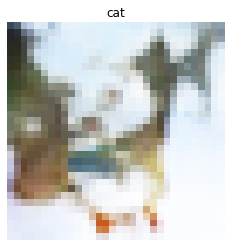

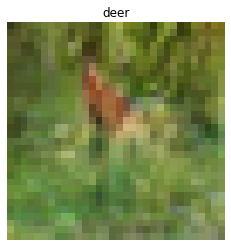

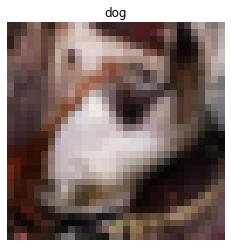

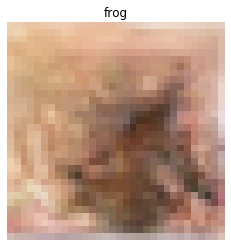

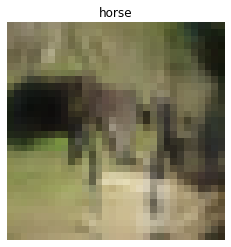

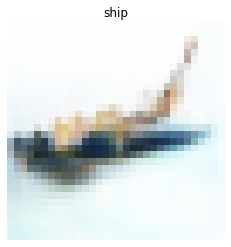

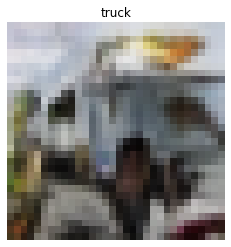

In [23]:
reconstructions_labels = np.arange(0, n_classes, dtype=np.int8)
reconstructions = c_dcgan.generate(size=n_classes, labels=reconstructions_labels)
plot_reconstructions(reconstructions, reconstructions_labels, labels)